In [3]:

import sys
print(sys.executable)
print(sys.version)
print(sys.version_info)

import math
import astropy
print('astropy',astropy.__version__ )
from spectral_cube import SpectralCube      # This is a handy package for working with 3D data cubes
from spectral_cube import LazyMask
from astropy.coordinates import SkyCoord
from reproject import reproject_interp      
from reproject.mosaicking import find_optimal_celestial_wcs 
import regions
import reproject
print('reproject',reproject.__version__)
import spectral_cube
print('spectral_cube',spectral_cube.__version__)
import numpy as np                          
import pylab                                
import matplotlib 
import matplotlib.gridspec as gridspec                                                                                             
import scipy
import astropy.io.fits as fits                                                          
from astropy.wcs import WCS                 
from astropy import units as u              
import pyspeckit as psk   
import astrodendro
import matplotlib.colors as colors
from matplotlib import pyplot as plt
# Suppress warnings we don't care about:
import sys
import gc

if not sys.warnoptions:
    import warnings
    warnings.simplefilter("ignore")
%matplotlib inline
from astrodendro.analysis import PPVStatistic


print(astrodendro.__file__)

from matplotlib.patches import Ellipse
import copy
from tqdm import tqdm
import radio_beam

from scipy.optimize import curve_fit
from scipy.optimize import leastsq
#%matplotlib widget
from astropy.convolution import Gaussian1DKernel

/home/ben/miniconda3/bin/python
3.8.5 (default, Sep  4 2020, 07:30:14) 
[GCC 7.3.0]
sys.version_info(major=3, minor=8, micro=5, releaselevel='final', serial=0)
astropy 5.1.dev153+gb740594dc
reproject 0.8
spectral_cube 0.6.1.dev22+g003ef16
/home/ben/.local/lib/python3.8/site-packages/astrodendro/__init__.py


# Part 1: Updates

In [2]:

#!py -m pip uninstall astropy
#!py -m pip install git+https://github.com/astropy/astropy
#!pip install emcee
!pip install corner
    
'''


!py -m pip install git+https://github.com/radio-astro-tools/spectral-cube.git
!py -m pip install reproject
!py -m pip install git+https://github.com/radio-astro-tools/spectral-cube.git 
!py -m pip install pyspeckit
!py -m pip install regions
!py -m pip install astrodendro
!py -m pip  install wcsaxes 
!py -m pip  install ipympl
!py -m pip install dask
!py -m pip install radio_beam
!py -m pip install casa_formats_io
#try:
#    !pip install casa_formats_io --no-binary :all:
#except:
#    !pip install casa_formats_io --no-cache --no-binary :all:

!py -m pip  install spectral_cube 
!py -m pip  install typing 
!py -m pip install mypy
!py -m pip  install typing_extensions 
'''

Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.


'\n\n\n!py -m pip install git+https://github.com/radio-astro-tools/spectral-cube.git\n!py -m pip install reproject\n!py -m pip install git+https://github.com/radio-astro-tools/spectral-cube.git \n!py -m pip install pyspeckit\n!py -m pip install regions\n!py -m pip install astrodendro\n!py -m pip  install wcsaxes \n!py -m pip  install ipympl\n!py -m pip install dask\n!py -m pip install radio_beam\n!py -m pip install casa_formats_io\n#try:\n#    !pip install casa_formats_io --no-binary :all:\n#except:\n#    !pip install casa_formats_io --no-cache --no-binary :all:\n\n!py -m pip  install spectral_cube \n!py -m pip  install typing \n!py -m pip install mypy\n!py -m pip  install typing_extensions \n'

# Part 6: Reprojection

In [7]:
#print(np.shape(bp))
#np.savetxt("bp.txt",np.array(bp[1][999999:9999999],dtype=int))
#np.savetxt("bp2.txt",np.array(bp[2][0:99999],dtype=int))
#Just Using CO 3-2 right now
#files = ["12CO_GC_359-000_mosaic.fit"]
files = ["CMZ_3mm_HCO+.fits"]
#files = ["12CO_GC_001-002_mosaic.fit"]
      


    #FIX THIS
    
    #####
FOV = [70,360]#pc

#Need to break it up into 30-wide vel slices to do the reprojection (ram-draw too high)
for i in range(0,100):
    
    sc = SpectralCube.read(files[0])  
    

    Nres=4.3*u.pc
    dist=8.178*10**3#pc
    res=  Nres/(dist)*180/np.pi*u.deg/u.pc#deg corresponding to ~3 pc
    print(res,"A")
    
    
    
    sc = sc[:,:,:]# Make a subcube
    
    #sc = sc[i*30:i*30+30,50:400,50:400]# Make a subcube
    #Put in the right system
    sc_kms = sc.with_spectral_unit(u.km/u.s,velocity_convention="radio") # Change units from Hz to km/s
    
    vel,RA,Dec = sc_kms.world[:,0,0]
    
    while(vel[0]<-250*u.km/u.s):
        sc_kms = sc.with_spectral_unit(u.km/u.s,velocity_convention="radio") # Change units from Hz to km/s
    
        
        sc_kms= sc_kms[i*15:i*15+15,:,:]# Make a subcube
        
        #Find the right velocity range
        vel,RA,Dec = sc_kms.world[:,0,0]
        
        i+=1
    if(vel[14]>250*u.km/u.s):
        print(vel[14])
        print("End Loop at",i)
        break
        
    sc = sc_kms.spectral_slab(-250. *u.km / u.s, 251. *u.km / u.s)  # Crop out velocities we don't care about    
    
    del sc_kms

    
    gal="GC"
        
    
    reheader = copy.deepcopy(sc.header)
    
    
    
    ## Find the number of expected pixels for the new resolution and the location of the left/right, up/down sides 
    if sc.header['cdelt1']>0:
        #pix_x    = sc.header['cdelt1']/5#(res/5.).to(u.degree).value*10
        pix_x    = (res/5.).to(u.degree).value
        origin_x = 357#sc.longitude_extrema[1].to(u.degree).value if gal=='GC' else sc.longitude_extrema[0].to(u.degree).value
        #origin_x = sc.longitude_extrema[1].to(u.degree).value if gal=='GC' else sc.longitude_extrema[0].to(u.degree).value

    else:
        #pix_x    = sc.header['cdelt1']/5#-1.*(res/5.).to(u.degree).value*10
        pix_x    = -(res/5.).to(u.degree).value
        origin_x = 3#(sc.longitude_extrema[0]).to(u.degree).value if gal=='GC' else (sc.longitude_extrema[1]).to(u.degree).value
        #origin_x = (sc.longitude_extrema[0]).to(u.degree).value if gal=='GC' else (sc.longitude_extrema[1]).to(u.degree).value

    if sc.header['cdelt2']>0:
        #pix_y    = sc.header['cdelt2']/5#(res/5.).to(u.degree).value*10
        pix_y    = (res/5.).to(u.degree).value
        origin_y = -1#sc.latitude_extrema[0].to(u.degree).value
        #origin_y = sc.latitude_extrema[0].to(u.degree).value

    else:
        #pix_y    = sc.header['cdelt2']/5#-1.*(res/5.).to(u.degree).value*10
        pix_y    = -(res/5.).to(u.degree).value
        origin_y = 1#sc.latitude_extrema[1].to(u.degree).value
        #origin_y = sc.latitude_extrema[1].to(u.degree).value



    if gal=='GC':
        #manually put in the size to correct for the 360->0 difference and just because it doesnt seem to work
        print("LA",((sc.longitude_extrema[0])),(sc.longitude_extrema[1]-360*u.degree),np.abs(pix_x))
        print("MA",sc.latitude_extrema,np.abs(pix_y))
        #npix_x   =int(np.ceil((sc.longitude_extrema[0]-(sc.longitude_extrema[1]-360*u.degree))/np.abs(pix_x)).value)
        #npix_y   =int(np.ceil(np.diff(sc.latitude_extrema, n=1)[0]/np.abs(pix_y)).value)
        npix_x   =int(6/np.abs(pix_x))
        npix_y   =int(2/np.abs(pix_y))

        print(npix_x,npix_y)

    #Correct the header to the expected pixels for the new res
    
    reheader['cdelt1'] = pix_x
    reheader['cdelt2'] = pix_y
    reheader['naxis1'] = npix_x
    reheader['naxis2'] = npix_y
    reheader['crval1'] = origin_x
    reheader['crval2'] = origin_y
    reheader['crpix1'] = 0
    reheader['crpix2'] = 0
    reheader['lbound1']=0
    reheader['lbound2']=0
    reheader['lbound3']=0
   
    try:
        del reheader['lonpole']
        del reheader['latpole']
        del reheader['wcsaxes']#Dont need these anymore, maybe?
    except:
        pass
    sc.allow_huge_operations=True
    print(sc.shape,np.nanmax(sc.hdu.data),'E')
    print(sc.wcs)
    sc = sc.reproject(reheader, order='bilinear', use_memmap=True, filled=True)
    print(sc.wcs)
    print(sc.shape,np.nanmax(sc.hdu.data),"F")
    sc.write("test.fits",overwrite=True)
    
    
    
    
    #center = SkyCoord('0359d56m39.24s', '-00d02m46.176s', frame='galactic')
    center = SkyCoord('-00d03m20.76s  ', '-00d02m46.176s', frame='galactic')
    
    beam = radio_beam.Beam(major=res, minor=res, pa=0*u.deg)

    sc.allow_huge_operations=True
    print(sc.shape,np.nanmax(sc.hdu.data),'EA')
    #Requires me to edit convolve.py and set allow_huge =True
    sc = sc.convolve_to(beam)#Smoothe to circular beam at 3 pc by 3 pc
    print(np.shape(sc),"B")

    

    
    '''
    Test3=SpectralCube.read(files[0])
    Test3.allow_huge_operations=True
    Test3=Test3.reproject(reheader, order='bilinear', use_memmap=True, filled=True)
    Test3.write("test10.fits",overwrite=True) 
    '''
    # regrid cube to target pixel size
    
    
    
    
    
    
    
        
    #Grow to fit the fov
    cdelt_x = u.Quantity(str(np.abs(sc.header['cdelt1']))+sc.header['cunit1'])
    cdelt_x_pc= cdelt_x * np.pi/180*8.178*10**3/u.deg*u.pc#in pc
    
    cdelt_y = u.Quantity(str(np.abs(sc.header['cdelt2']))+sc.header['cunit2'])
    cdelt_y_pc= cdelt_y * np.pi/180*8.178*10**3/u.deg*u.pc#in pc
    
    #center = SkyCoord('0359d56m39.24s', '-00d02m46.176s', frame='galactic')
    center = SkyCoord('-00d03m20.76s  ', '-00d02m46.176s', frame='galactic')
    center_ra_pix,center_dec_pix = int(sc.wcs[:][:][0].world_to_pixel(center)[0]),int(sc.wcs[:][:][0].world_to_pixel(center)[1])
    
    print(center_dec_pix,center_ra_pix)
    
    print((sc.wcs[:][:][0].pixel_to_world(center_dec_pix,center_ra_pix)),center_dec_pix,center_ra_pix)
    PixFov = [int(FOV[0]/(cdelt_x/u.deg*np.pi/180*8.178*10**3))/2,int(FOV[1]/(cdelt_y/u.deg*np.pi/180*8.178*10**3))/2]

    
    pixels = np.zeros(np.shape(sc))           
    for lmi in range(np.shape(sc)[0]):
        for lmj in range(np.shape(sc)[1]):
            for lmk in range(np.shape(sc)[2]):
                
                up_pixels = abs(lmj-center_dec_pix)#Should not be over the fov in the upwards direction (relative to 0 degrees)
                side_pixels = abs(lmk-center_ra_pix)#Should not be over the fov in the side-side direction (relative to 0 degrees)
                
                if(up_pixels<PixFov[0] and side_pixels<PixFov[1]):
                    #print(lmj,lmk,np.shape(sc))
                    pixels[lmi][lmj][lmk] = 1#good
            #print("Up pix",up_pixels,"Up pix fov",PixFov[0],"side pix",side_pixels,"side pix fov",PixFov[1],"lmj (dec)",lmj,"lmk (ra)",lmk,"center dec pix",center_dec_pix,"center ra pix",center_ra_pix,cdelt_x_pc,cdelt_y_pc)

    bp = np.where(pixels!=1)
    
    #Mask teh pixels outside the fov
    scCopy = sc.hdu
    print(bp,np.shape(scCopy),np.shape(sc))
    print(scCopy.shape,np.nanmax(scCopy.data),'G')
    scCopy.data[bp]=np.nan
    print(scCopy.shape,np.nanmax(scCopy.data),'H')
    sc = SpectralCube.read(scCopy)
    del scCopy

    '''
    # calculate pixel position of subcube
    npix_x = int(np.round(PixFov[1]/2./cdelt_x_pc.value))
    npix_y = int(np.round(PixFov[0]/2./cdelt_y_pc.value))
    cutout_x = [center_ra_pix-npix_x, center_ra_pix+npix_x]
    cutout_y = [center_dec_pix-npix_y, center_dec_pix+npix_y]

    # check image dimensions
    grow_x1 = 0-cutout_x[0] if cutout_x[0]<0 else 0
    grow_x2 = cutout_x[1]-sc.header['naxis1'] if cutout_x[1]>sc.header['naxis1'] else 0
    grow_x  = np.max([grow_x1, grow_x2])

    grow_y1 = 0-cutout_y[0] if cutout_y[0]<0 else 0
    grow_y2 = cutout_y[1]-sc.header['naxis2'] if cutout_y[1]>sc.header['naxis2'] else 0
    grow_y  = np.max([grow_y1, grow_y2])

    if grow_x>0 or grow_y>0:
        print("Growing image to allow cutting out symmetric subimage.")
        shape = np.shape(sc)
        print(shape,grow_x,grow_y,grow_y1,grow_y2,cutout_y,npix_y,PixFov,center_dec_pix,cdelt_y,cdelt_y_pc)
        print("Up pix fov",PixFov[0],"side pix fov",PixFov[1],"center dec pix",center_dec_pix,"center ra pix",center_ra_pix)
        grown = np.full((shape[0],shape[1]+2*grow_y,shape[2]+2*grow_x),np.nan)
            
    for v,V in tqdm(enumerate(sc.hdu.data)):
        for y,Y in enumerate(V):
            for x,X in enumerate(Y):
                grown[v,y+grow_y,x+grow_x] = X
        scCopy = sc.hdu
        scCopy.data = grown
    print(np.shape(sc))
    sc = SpectralCube.read(scCopy)#HAve to do this since cubes are not assignable
    print(np.shape(sc))
    del scCopy

    '''
    
    vel = np.arange(-250,251,3.3)*u.km/u.s
    CO_J3_2 = sc
    del sc
    CO_J3_2.allow_huge_operations=True

    #Write the intermediary cubes that will then be spliced together
    CO_J3_2.write(("4.3pc_beam_"+str(i)+'_CMZ_HCOp_J1_0_70x360pc.fits'),overwrite=True)      
    del CO_J3_2

        



print("done")



0.030126174114239904 deg A
LA 1.8151153422253907 deg -0.731781984769384 deg 0.006025234822847981
MA [-0.31499077  0.23167801] deg 0.006025234822847981
995 331
(15, 165, 765) 2.3734605 E
WCS Keywords

Number of WCS axes: 3
CTYPE : 'GLON-SIN'  'GLAT-SIN'  'VRAD-W2F'  
CRVAL : 0.541666678728  -0.0416666712776  283.1181211448065  
CRPIX : 383.0  83.0  136.5  
PC1_1 PC1_2 PC1_3  : 1.0  0.0  0.0  
PC2_1 PC2_2 PC2_3  : 0.0  1.0  0.0  
PC3_1 PC3_2 PC3_3  : 0.0  0.0  1.0  
CDELT : -0.00333333353753  0.00333333353753  1811.8575705196015  
NAXIS : 765  165  332
WCS Keywords

Number of WCS axes: 3
CTYPE : 'GLON-SIN'  'GLAT-SIN'  'VRAD-W2F'  
CRVAL : 3.0  -1.0  283.11812114481  
CRPIX : 0.0  0.0  136.5  
PC1_1 PC1_2 PC1_3  : 1.0  0.0  0.0  
PC2_1 PC2_2 PC2_3  : 0.0  1.0  0.0  
PC3_1 PC3_2 PC3_3  : 0.0  0.0  1.0  
CDELT : -0.00602523482284798  0.006025234822847981  1811.8575705196001  
NAXIS : 995  331  15
(15, 331, 995) 1.5746692 F
(15, 331, 995) 1.5746692 EA
0.0 0.0
0.0007902974658322844 0.0007902

In [2]:
#Splice


vel = np.arange(-250,251,3.3)*u.km/u.s    
for i in range(0,100):
    try:
        
        sc=SpectralCube.read(("4.3pc_beam_"+str(i)+'_CMZ_HCOp_J1_0_70x360pc.fits'))
        print(sc.mask,type(sc.mask),sc.shape)
        sc = sc[:,:,:]
        print(i)
        
        
        if i==3:
            reheader = sc.header
            rewcs = sc.wcs


        print(type(sc))
        if i ==3:
            scW=SpectralCube.read(("4.3pc_beam_"+str(i)+'_CMZ_HCOp_J1_0_70x360pc.fits'))
            scW = scW[:,:,:]
            print(i,"a")
            mask = scW.mask.include() #Need to create a mask because it doesn't get splcied
            print(i,"b")
        else:


            if i ==4:
                scW = np.concatenate((scW[:].hdu.data,sc[:].hdu.data),dtype = type(sc))
                print(i,"c")
                print(type(scW))
                mask = np.concatenate((mask[:],sc[:].mask.include()),dtype = type(sc[:].mask.include()))
                print(i,"d")
            else:
                scW = np.concatenate((scW[:],sc.hdu.data[:]),dtype = type(sc))
                print(i,"e")
                mask = np.concatenate((mask[:],sc[:].mask.include()),dtype = type(sc[:].mask.include()))
                print(i,"f")


        print(np.shape(scW))
    except:
        print(i,"pass")
        pass
    

def duh(lol):
    gp = np.where(lol!=np.nan)
    lol[gp]=True
    return lol #Anywhere that has data will be unmasked
reheader["NAXIS3"] = len(scW)
Full_Mask = LazyMask(function = duh,data = mask, wcs = rewcs)
scWsc = SpectralCube(data = scW,wcs = rewcs, header = reheader, mask = Full_Mask)#The spliced cube

scWsc.allow_huge_operations=True
scWsc = scWsc*sc[0][0][0].unit#Add unit back in
del sc
fwhm_factor = np.sqrt(8*np.log(2))

scWsc.allow_huge_operations=True


#scWsc = scWsc.spectral_smooth(Gaussian1DKernel(4/fwhm_factor))
#scWsc = scWsc.spectral_smooth(Gaussian1DKernel(4/fwhm_factor))
vel = np.arange(-250,251,3.3)*u.km/u.s    

G_width = np.sqrt(abs(scWsc.header["CDELT3"]**2-3.3**2))
#scWsc = scWsc.spectral_smooth(Gaussian1DKernel(G_width/fwhm_factor))#Preserves information from the pixels lost in downsampling

scWsc = scWsc.spectral_interpolate(spectral_grid=vel) # Match velocities to -250 251 range


#scWsc.write("CMZ_Spliced_Reprojected_Whole_HCOp_10.fits",overwrite=True)
scWsc.write("CMZ_Spliced_Reprojected_Whole_HCOp_10_No_Gauss.fits",overwrite=True)

del scWsc

print("done")         

0 pass
1 pass
2 pass
<spectral_cube.masks.LazyMask object at 0x7f5b3c31bfd0> <class 'spectral_cube.masks.LazyMask'> (15, 331, 995)
3
<class 'spectral_cube.spectral_cube.SpectralCube'>
3 a
3 b
(15, 331, 995)
<spectral_cube.masks.LazyMask object at 0x7f5ac5ba3220> <class 'spectral_cube.masks.LazyMask'> (15, 331, 995)
4
<class 'spectral_cube.spectral_cube.SpectralCube'>
4 c
<class 'numpy.ndarray'>
4 d
(30, 331, 995)
<spectral_cube.masks.LazyMask object at 0x7f5ac5bfd310> <class 'spectral_cube.masks.LazyMask'> (15, 331, 995)
5
<class 'spectral_cube.spectral_cube.SpectralCube'>
5 e
5 f
(45, 331, 995)
<spectral_cube.masks.LazyMask object at 0x7f5ac5bfe6a0> <class 'spectral_cube.masks.LazyMask'> (15, 331, 995)
6
<class 'spectral_cube.spectral_cube.SpectralCube'>
6 e
6 f
(60, 331, 995)
<spectral_cube.masks.LazyMask object at 0x7f5ac3598f70> <class 'spectral_cube.masks.LazyMask'> (15, 331, 995)
7
<class 'spectral_cube.spectral_cube.SpectralCube'>
7 e
7 f
(75, 331, 995)
<spectral_cube.masks.Lazy

In [9]:
#match noise

#NGCCO32_Noise = 0.115#*u.K
NGCCO32_Noise=0.37603338214618737*u.K
path ="CMZ_Spliced_Reprojected_Whole_HCOp_10.fits"
Qp = SpectralCube.read(path).with_spectral_unit(u.km/u.s,velocity_convention="radio") 
Qp.allow_huge_operations=True
Qp = Qp[:,:,:]
Q = Qp.to(u.K)#Jy to Kelvin

sc = Q.unmasked_copy()

m = (np.nanstd(sc.hdu.data[0,:,:])) #Noise K

print(m,"Noise (K)")





npixels = np.product(Q.hdu.data.shape)

target_noise = float(NGCCO32_Noise/u.K)
actual_noise = m
additional_sigma = np.sqrt(target_noise**2 - actual_noise**2)

additional_noise = np.random.normal(0., additional_sigma, npixels)
additional_noise = np.reshape(additional_noise, Q.hdu.data.shape)

new_data = Q.hdu.data+additional_noise
QCopy = Q.hdu
QCopy.data = new_data
Q = SpectralCube.read(QCopy)
del QCopy

newName = "Noise_Matched_"+path
Q.write(newName,overwrite=True)

print("Doen")



0.00802031832999669 Noise (K)
Doen


# Part 8: Dendograms

In [18]:
Names=[1,2,3,4,5,6,7,8,9,10,11,12] #An array for the dendrogram names

In [1]:

#Create a function that uses the dendrogram input to calculate all the quantities, and has the size and linewidth requirements of the Shetty paper
#Requires the computed dendrogram, the data from the line image, the velocity axis, and the data from the Continuum image, as well as metadata for the structures
#Finds Size, Linewidth, Luminosity, and Column Density of a structure for each structure and returns them in [[][]] arrays [Leaves][Branches]
#Continuum is in Jansky/Beam, Line data should have the unit specified in the metadata as 'data_unit'

def Dendro_Arrays(Dendrogram,LineData,DataVel,ContData,metadata,ColD = True):
    
    SizeA,SigmaA,LuminA,CDA,SIDS,MOM0_FLUX = [[],[],[],[]],[[],[],[],[]],[[],[]],[[],[]],[[],[]],[[],[]]
    sliced= LineData[12]
    CubeShape = np.shape(sliced)
    DataShape=[[0,0],[0,0]]#The part of the cube that actually has data
    for lmi in range(CubeShape[0]):
        allData=np.nansum(sliced[lmi])
        if(allData>0 or allData<0):
            DataShape[0][0] = lmi+3
            break
    for lmi in range(CubeShape[0]):
        allData=np.nansum(sliced[CubeShape[0] - lmi -1])
        if(allData>0 or allData<0):
            DataShape[0][1] = CubeShape[0] - lmi -3
            break
    for lmi in range(CubeShape[1]):
        allData=(sliced[DataShape[0][0],lmi])
        if(allData>0 or allData<0):
            DataShape[1][0] = lmi+3
            break
    for lmi in range(CubeShape[1]):
        allData=(sliced[DataShape[0][0],CubeShape[1] - lmi -1])
        if(allData>0 or allData<0):
            DataShape[1][1] = CubeShape[1] - lmi -3
            break
    print(DataShape,CubeShape)
    for t in Dendrogram.all_structures: 

        I = t.indices()
        Cont = True
        if t.is_branch:
                if t.parent==None:
                    Cont=True
                else:
                    Cont = True
        
        for lmi in range(len(I[0])):
            if(I[1][lmi]<=DataShape[0][0] or I[1][lmi]>=DataShape[0][1] or I[2][lmi]<=DataShape[1][0] or I[2][lmi]>=DataShape[1][1]):
                #print(I[1][lmi],I[0][lmi])
                Cont=False


        if(Cont):
            s = PPVStatistic(t,metadata=metadata)
            #print((float((s.radius*np.pi/180*8.178*10**-3/u.deg)))*10**6)
            #if((float((s.radius*np.pi/180*8.178*10**-3/u.deg)))*10**6<18 and (float((s.radius*np.pi/180*8.178*10**-3/u.deg)))*10**6>4.3/5 and (float(s.v_rms/u.km*u.s))>.01):
            #if((float((s.radius*np.pi/180*8.178*10**-3/u.deg)))*10**6<18 and (float((s.radius*np.pi/180*8.178*10**-3/u.deg)))*10**6>4.3/5 and (float(s.v_rms/u.km*u.s))>.01):
            if((float((s.radius*np.pi/180*8.178*10**-3/u.deg)))*10**6>4.3/5 and (float(s.v_rms/u.km*u.s))>.01):
            #?
            #if((float((s.radius*np.pi/180*8.178*10**-3/u.deg)))*10**6>.9 and (float(s.v_rms/u.km*u.s))>.01):

                nproj_pix=len(set(zip(*tuple(I[i] for i in [1,2]))))
                v_IWM = np.nansum(LineData[I]*(DataVel[I[0]])/u.km*u.s)/np.nansum(LineData[I])
                sig_Sh = np.sqrt(np.nansum(LineData[I]*((DataVel[I[0]])/u.km*u.s-v_IWM)**2)/np.nansum(LineData[I])) 

                #The flux from the continuum
                #Convert to Jansky from Jansky per beam:
                if(ColD ==True):
                    Cont_Flux=0

                    proj = tuple(set(zip(*tuple(I[i] for i in [1,2]))))
                    for lmi in range(len(proj)):

                        Cont_Flux+=ContData[proj[lmi]]
                    Cont_Flux=Cont_Flux/(metadata['beam_area_ratioc']*(2*np.sqrt(2*np.log(2))))*u.pix**2*u.beam/u.beam*u.Jy#SHould be input as Jansky /beam and will be converted to Jansky, then to unitless. The beam is changed from FWHM to Gaussian
                    Dust_Column = Flux_to_Mass(Cont_Flux)*Num_per_kg/((s.radius*np.pi/180*8.178*10**-3/u.deg)**2*(3.086*10**24)**2)/np.pi*(1.989*10**30*u.kg/u.M_sun)/u.kg
                else:
                    Dust_Column=0
                if(str(Dust_Column) == str(np.nan) or str(Dust_Column)==str(np.inf)):
                    Dust_Column=0
                lum = Flux_to_Lum(s.flux)
                s_flux = s.flux

                Index = tuple(I[i] for i in [0,1,2])
                K_Km_s_Flux=np.nansum(LineData[Index]*metadata["velocity_scale"])#Find the total flux from the structures in K km/s, assuming the input data is in K as it should be, 

                if(t.is_leaf):

                    SizeA[0].append((float((s.radius*np.pi/180*8.178*10**-3/u.deg)))) #define size as astrodendro
                    SigmaA[0].append((float(s.v_rms/u.km*u.s)))#
                    CDA[0].append(float(Dust_Column))
                    LuminA[0].append(float(lum*u.Hz*u.s/u.erg))
                    SIDS[0].append(float(t.idx))
                    MOM0_FLUX[0].append(float(K_Km_s_Flux*u.s/u.km))
                if(t.is_branch	):

                    SizeA[1].append((float((s.radius*np.pi/180*8.178*10**-3/u.deg)))) #define size as astrodendro
                    SigmaA[1].append((float(s.v_rms/u.km*u.s)))#
                    CDA[1].append(float(Dust_Column))
                    LuminA[1].append(float(lum*u.Hz*u.s/u.erg))
                    SIDS[1].append(float(t.idx))
                    MOM0_FLUX[1].append(float(K_Km_s_Flux*u.s/u.km))
    SizeA[0] = np.array(SizeA[0],dtype=type(1.))
    SizeA[1] = np.array(SizeA[1],dtype=type(1.))
    SizeA[2] = np.array(SizeA[2],dtype=type(1.))
    SizeA[3] = np.array(SizeA[3],dtype=type(1.))
    SigmaA[0] = np.array(SigmaA[0],dtype=type(1.))
    SigmaA[1] = np.array(SigmaA[1],dtype=type(1.))
    SigmaA[2] = np.array(SigmaA[2],dtype=type(1.))
    SigmaA[3] = np.array(SigmaA[3],dtype=type(1.))
    CDA[0] = np.array(CDA[0],dtype=type(1.))
    CDA[1] = np.array(CDA[1],dtype=type(1.))
    LuminA[0] = np.array(LuminA[0],dtype=type(1.))
    LuminA[1] = np.array(LuminA[1],dtype=type(1.))
    SIDS[0] = np.array(SIDS[0],dtype=type(1.))
    SIDS[1] = np.array(SIDS[1],dtype=type(1.))
    MOM0_FLUX[0] = np.array(MOM0_FLUX[0],dtype=type(1.))
    MOM0_FLUX[1] = np.array(MOM0_FLUX[1],dtype=type(1.))
    
    return np.array(SizeA),np.array(SigmaA),np.array(CDA),np.array(LuminA),np.array(SIDS),np.array(MOM0_FLUX)

#Make a function to make an image 

#Data to plot, minimum of color bar, maximum, WCS projection for coords, and position of the image in the larger figure
def Make_Plot(Name,Name2,Data,vmin,vmax,WCS,rows,columns,index,show):
    

    ax = pylab.subplot(rows,columns,index,projection=WCS) 
    RA = ax.coords[0]                                                                  # 
    Dec = ax.coords[1]
    im = pylab.imshow(Data,vmin=vmin,vmax=vmax,cmap='rainbow')
    RA.set_ticks(size=-3)                                                                                      
    Dec.set_ticks(size=-3) 
    RA.set_ticklabel(exclude_overlapping=True) 
    Dec.set_ticklabel(exclude_overlapping=True)                                                                                     
    pylab.xlabel('Right Ascension',fontsize=20,labelpad=1)                               
    pylab.ylabel('Declination',fontsize=20,labelpad=1)
    ax.tick_params(axis = 'both', which = 'major', labelsize = 15)    
    cb=pylab.colorbar(im,fraction=0.1,pad=0.0)                                     
    cb.set_label(label=Name,fontsize=10,rotation=270,labelpad=20) 
    cb.ax.tick_params(which = 'major', labelsize = 10)   
    pylab.annotate(s=Name2,fontsize=10,xy=(0.02,1.05),xycoords="axes fraction")  
    if(show==True):
        pylab.show()
def Make_Plot_Anno(Name,Name2,Data,vmin,vmax,WCS,rows,columns,index,show,pos1,pos2):
    

    ax = pylab.subplot(rows,columns,index,projection=WCS) 
    RA = ax.coords[0]                                                                  # 
    Dec = ax.coords[1]
    im = pylab.imshow(Data,vmin=vmin,vmax=vmax,cmap='rainbow')
    RA.set_ticks(size=-3)                                                                                      
    Dec.set_ticks(size=-3) 
    RA.set_ticklabel(exclude_overlapping=True) 
    Dec.set_ticklabel(exclude_overlapping=True)                                                                                     
    pylab.xlabel('Right Ascension',fontsize=20,labelpad=1)                               
    pylab.ylabel('Declination',fontsize=20,labelpad=1)
    ax.tick_params(axis = 'both', which = 'major', labelsize = 15)    
    cb=pylab.colorbar(im,fraction=.1,pad=0.0)                                     
    cb.set_label(label=Name,fontsize=10,rotation=270,labelpad=20) 
    cb.ax.tick_params(which = 'major', labelsize = 10)   
    pylab.annotate(s=Name2,fontsize=10,xy=(pos1,pos2),xycoords="axes fraction")  
    if(show==True):
        pylab.show()
        
        
#Put this up here for the column density map
def Flux_to_Mass(flux):
    J_to_e = 10**-23*u.erg/u.s/u.cm**2/u.Hz/u.Jy
    flux_erg = flux*J_to_e
    L = 4*np.pi*(8.178*10**-3*3.086*10**24)**2*flux_erg*u.cm**2 #Megaparsec is converted to cm
    
    
    a_850 = 6.7*10**19*u.erg/u.s/u.Hz/u.M_sun #6.7+-1.7
    
    M_mol = L/a_850#Just in Solar mass*1.989*10**30*u.kg/u.M_sun #Determines mass of the cont for 850 in kg
    return M_mol
def Flux_to_Lum(flux):
    J_to_e = 10**-23*u.erg/u.s/u.cm**2/u.Hz/u.Jy
    flux_erg = flux*J_to_e
    L = 4*np.pi*(8.178*10**-3*3.086*10**24)**2*flux_erg*u.cm**2 #Megaparsec is converted to cm
    
    return L


def Find_Pixel_D(flux,metadata,sub = "Nope"):
    center = SkyCoord(l=359.94487501*u.degree,b=-00.04391769*u.degree, frame='galactic')
    
    x,y = [metadata["Cwcs"].world_to_pixel(center)[0],(metadata["Cwcs"].world_to_pixel(center)[1])]
    d0 = 8.178 *10**-3*u.Mpc #mpc
    D_Es = np.empty(np.shape(flux))
    for lmi in range(len(flux)):
        for lmj in range(len(flux[lmi])):
            #Find the distance to earth from every pixel
            D_Es[lmi][lmj] = np.sqrt(d0**2 + (d0*np.tan(u.rad*metadata['arc_per_pix']*(np.sqrt((lmj-x)**2+(lmi-y)**2))/3600*np.pi/180/u.arcsec*u.pix))**2 )/u.Mpc#Has to be unitless so it saves, so bring the unit back when it is loaded
            
    #print(D_Es)
    if(sub=="Nope"):
        np.save("Pixel_D",D_Es)
    else:
        np.save(sub,D_Es)

#path ="Noise_Matched_CMZ_CO_3_2_355_005.fits"
#cmz_cube=SpectralCube.read(path)
#Find_Pixel_D(cmz_cube.moment0().hdu.data,metadata)

#Return a cropped cube for some ra and dec, also crops the velocity axis if needed (0 for no crop)
def Crop(cube,WCS,Np1,Np2,BadVel,D2):
    NraDP1 = [int(WCS.world_to_pixel(Np1)[0]),int(WCS.world_to_pixel(Np1)[1])]
    NraDP2 = [int(WCS.world_to_pixel(Np2)[0]),int(WCS.world_to_pixel(Np2)[1])]
    if(D2==False):
        return cube[BadVel:np.shape(cube)[0]-BadVel,NraDP1[1]:NraDP2[1],NraDP1[0]:NraDP2[0]]
    if(D2==True):
        return cube[NraDP1[1]:NraDP2[1],NraDP1[0]:NraDP2[0]]
    
#Make_Plot("Tes","Test2",Q.moment0().hdu.data,0,0,Q.wcs[:][:][0],2,2,1,True)
#Make_Plot("Tes","Test2",Q.moment0().hdu.data,0,0,Q.wcs[:][:][0],2,2,2,True)

CMZ_HCOp 1-0_Abs_New ['CMZ_HCOp 1-0_Abs_New', 'CMZ_HCN 1-0_Abs_New', 'CMZ_H13CN 1-0_Abs_New', 'CMZ_H13CO+ 1-0_Abs_New', 'CMZ_CO 3-2_Abs_New', 'CMZ_CO 3-2_Abs', 'CMZ_CO 3-2_Abs', 'CMZ_CO 3-2_Abs']
OG noise =  0.00802031832999669 K
NGC_Matched noise =  0.023267549056702922 K


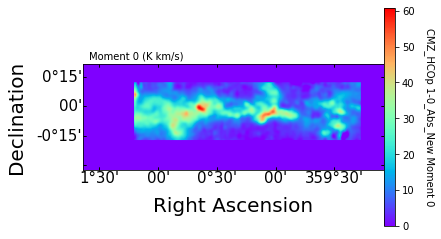

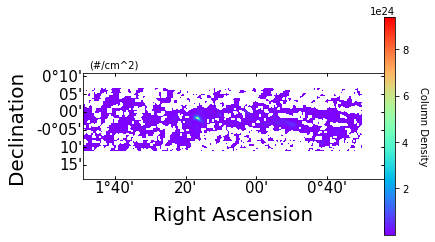

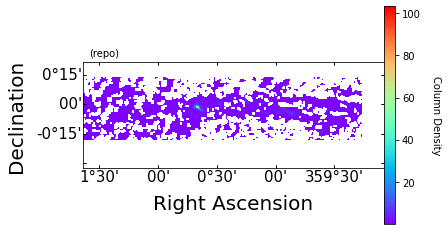

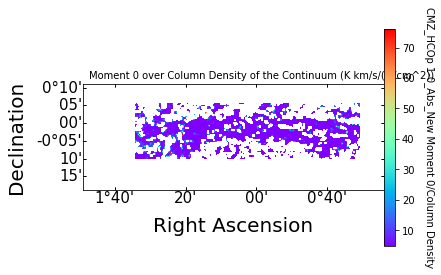

dend number 0
(243,)
(182,)
(152, 150, 425)
(152, 150, 425)
dend number 1
(183,)
(130,)
(152, 150, 425)
(152, 150, 425)
dend number 2
(146,)
(103,)
(152, 150, 425)
(152, 150, 425)
dend number 3
(118,)
(94,)
(152, 150, 425)
(152, 150, 425)
dend number 4
(105,)
(81,)
(152, 150, 425)
(152, 150, 425)
done


In [4]:


#hCO 
#
Num=0
Ram_Limiter=1#What percent of the cube my ram can handle



Name = "CMZ_HCOp 1-0_Abs_New"

Num_per_kg= 6.0221409*10**23/(2.8*10**-3)#6.0221409*10**23/29.0180*10**-3#num/kg for h2

try:
    Names= list(np.load("Names_CMZ_New.npy"))
except:
    Names= list(np.load("Names_CMZ.npy"))
Names[Num] = Name

np.save("Names_CMZ_New",Names)

print(Name,Names)



path ="Noise_Matched_CMZ_Spliced_Reprojected_Whole_HCOp_10.fits"#"Noise_Matched_"+'CMZ_CO_3_2_358_002.fits'
path="CMZ_Spliced_Reprojected_Whole_HCOp_10.fits"
path_No_Gauss="CMZ_Spliced_Reprojected_Whole_HCOp_10_No_Gauss.fits"

pathog="CMZ_Spliced_Reprojected_Whole_HCOp_10.fits"#With Gauss

pathCont = 'CMZ_Continuum_Splice.fits'


#Make subcube

Qp = SpectralCube.read(path).with_spectral_unit(u.km/u.s,velocity_convention="radio") 
Qp.allow_huge_operations=True
Qp = Qp[:,:,:]#Get rid of the excess nan parts
Q = Qp.to(u.K)#Jy to Kelvin
sc = Q.unmasked_copy()
scW = sc.wcs[:][:][0]
dat = sc.hdu.data[int(len(sc)*((1-Ram_Limiter)/2)):int(len(sc)*(Ram_Limiter + (1-Ram_Limiter)/2)),:,:]
scn = sc[int(len(sc)*((1-Ram_Limiter)/2)):int(len(sc)*(Ram_Limiter + (1-Ram_Limiter)/2)),:,:]

scF = scn[:,75:225,225:650]#Crop(scn,scn.wcs[:][:][0],cen_p1,cen_p2,0,False)
datn = dat[:,75:225,225:650]#Crop(dat,scn.wcs[:][:][0],cen_p1,cen_p2,0,False)z

QpNG = SpectralCube.read(path_No_Gauss).with_spectral_unit(u.km/u.s,velocity_convention="radio") 
QpNG.allow_huge_operations=True
QpNG = QpNG[:,:,:]#Get rid of the excess nan parts
QNG = QpNG.to(u.K)#Jy to Kelvin
scNG = QNG.unmasked_copy()

datNG = scNG.hdu.data[int(len(scNG)*((1-Ram_Limiter)/2)):int(len(scNG)*(Ram_Limiter + (1-Ram_Limiter)/2)),:,:]
del scNG 
del QpNG 
del QNG


datnNG = datNG[:,75:225,225:650]#Crop(dat,scn.wcs[:][:][0],cen_p1,cen_p2,0,False)z


Qpog = SpectralCube.read(pathog).with_spectral_unit(u.km/u.s,velocity_convention="radio") 
Qpog.allow_huge_operations=True
Qog = Qpog.to(u.K)#Jy to Kelvin
scog = Qog.unmasked_copy()


mog = (np.nanstd(scog.hdu.data[0,:,:])) #Noise K
Non_nan=((sc.hdu.data[0,:,:]>0)  | (sc.hdu.data[0,:,:]<0 ))

m = (np.nanstd(sc.hdu.data[0,:,:],where= Non_nan)) #Noise K

Non_nanNG=((datNG>0)  | (datNG<0 ))
mNG = (np.nanstd(datNG[0,:,:],where= Non_nan)) #Noise K
print("OG noise = ",mog,"K")
print("NGC_Matched noise = ",m,"K")
del scog
del Qog
del Qpog

#Continuum image
scCont = spectral_cube.Projection.from_hdu(fits.open(pathCont)[0])
#Do the same thing to the continuum image
scCont.allow_huge_operations=True
scContW = scCont.reproject(scF.moment0().header)
#m=.115


#Put this up here for the column density map
metadata = {}
metadata["distance"] = 8.178*10**-3*u.Mpc
arc_per_pix_yc =  abs(scContW.hdu.header["CDELT1"]*3600.0 * u.arcsec)/u.pix
arc_per_pix_xc =  abs(scContW.hdu.header["CDELT2"]*3600.0 * u.arcsec)/u.pix
beam_majorc =  scContW.hdu.header["BMAJ"]*3600.0 * u.arcsec
beam_minorc =  scContW.hdu.header["BMIN"]*3600.0 * u.arcsec
beam_area_ratioc = beam_minorc*beam_majorc/arc_per_pix_yc/arc_per_pix_xc*1.13309#beam_area_ratioc = beam_minorc*beam_majorc/arc_per_pix_yc/arc_per_pix_xc#This is for FWHM, use *(2*np.sqrt(2*np.log(2)))**2#For gaussian beam
metadata['beam_area_ratioc']=beam_area_ratioc
pc_per_pixelc = abs(scContW.hdu.header["CDELT1"])/180*np.pi*metadata['distance']/u.Mpc
header = scF.hdu.header
metadata['arc_per_pix_y'] =  abs(header["CDELT1"]*3600.0 * u.arcsec)/u.pix
metadata['arc_per_pix_x'] =  abs(header["CDELT2"]*3600.0 * u.arcsec)/u.pix
metadata['beam_major'] =  header["BMAJ"]*3600.0 * u.arcsec
metadata['beam_minor'] =  header["BMIN"]*3600.0 * u.arcsec
beam_area_ratio = metadata['beam_minor']*metadata['beam_major']/metadata['arc_per_pix_y']/metadata['arc_per_pix_x']*1.13309#beam_area_ratio = metadata['beam_minor']*metadata['beam_major']/metadata['arc_per_pix_y']/metadata['arc_per_pix_x']#This is for FWHM, use *(2*np.sqrt(2*np.log(2)))**2#For gaussian beam
Continuum_Data  =scContW.hdu.data
scWCS = scF.wcs[:][:][0]

moment_0_sub  = scF.to(u.K).moment(order=0,how='slice')            # Calculate the Moment 0 map 



######Moment 0 for both
######and cont
Make_Plot((Name+" Moment 0"),"Moment 0 (K km/s)",moment_0_sub.hdu.data,0,np.nanmax(moment_0_sub.hdu.data),moment_0_sub.wcs,1,1,1,True)


cSD = (Flux_to_Mass(scContW.hdu.data*u.Jy/u.beam/beam_area_ratioc*u.pix**2*u.beam)/(pc_per_pixelc*10**6*3.086*10**18*u.cm)**2)*(1.989*10**30*u.kg/u.M_sun)*Num_per_kg/u.kg #Flux goes to luminosity for a gaussian beam and goes to column density for square pixels, mass goes to kg to number




rm=moment_0_sub.hdu.data/cSD
rmU = rm*u.K*u.km/u.s#Just put back in the units
rmU = np.array(rmU /(u.K*u.km/u.s)/u.cm**2*10**22,dtype='float64')#Now remove them all

######ratio
   
bp = np.where(cSD<=.1*10**22/u.cm**2)
bp2 = np.where( moment_0_sub.hdu.data < .22)
Continuum_Data[bp] = np.nan

cSD[bp]=np.nan
rmU[bp]=np.nan
rmU[bp2]=np.nan

Make_Plot("Column Density","(#/cm^2)",cSD,float(np.nanmin(cSD*u.cm**2)),float(np.nanmax(cSD*u.cm**2)),scCont.wcs,1,1,1,True)

Make_Plot("Column Density","(repo)",scContW.hdu.data,float(np.nanmin(scContW.hdu.data)),float(np.nanmax(scContW.hdu.data)),scContW.wcs,1,1,1,True)


Make_Plot((Name+" Moment 0/Column Density"),"Moment 0 over Column Density of the Continuum (K km/s/(#/cm^2))",rmU,np.nanmean(rmU)*.5,abs(np.nanmean(rmU))*8,scCont.wcs,1,1,1,True)





#Calculate many dendrograms
for lmi in range(5):
    print("dend number",lmi)
    #Range from min SNR of 3 to 8, and keep the delta/snr ratio at 1/5
    d = astrodendro.Dendrogram.compute(datn,min_delta=m*(1/5+lmi/5),min_value=m*(3+lmi),min_npix=beam_area_ratio.value*3) #The main culprit
    #Cube with no gaussian smoothing
    dNG = astrodendro.Dendrogram.compute(datnNG,min_delta=mNG*(1/5+lmi/5),min_value=mNG*(3+lmi),min_npix=beam_area_ratio.value*3) #The main culprit
    print(np.shape(d))
    print(np.shape(dNG))
    print(np.shape(datn))
    print(np.shape(datnNG))
    dName = Name+"Dendrogram_Gauss_SNR_"+str((3+lmi))+".fits"
    dNameNG = Name +"Dendrogram_No_Gauss_SNR_"+str((3+lmi))+".fits"
    #Had to change astropy so overwrite is always true
    d.save_to(dName)
    dNG.save_to(dNameNG)
    
    #d = astrodendro.Dendrogram.compute(datn,min_delta=m,min_value=m*5,min_npix=beam_area_ratio.value) #The main culprit
    #d = astrodendro.Dendrogram.compute(datn,min_delta=m,min_value=m*5,min_npix=beam_area_ratio.value*3) #The main culprit

print("done")

noise =  0.023267549056702922 K
noise ng =  0.03475814130698906 K
1 89188526000.0 Hz 0.003361334371643276 m
(243,)
(182,)
(152, 150, 425)
(152, 150, 425)
[[45, 120], [75, 388]] (150, 425)
[[45, 120], [75, 388]] (150, 425)
(146,)


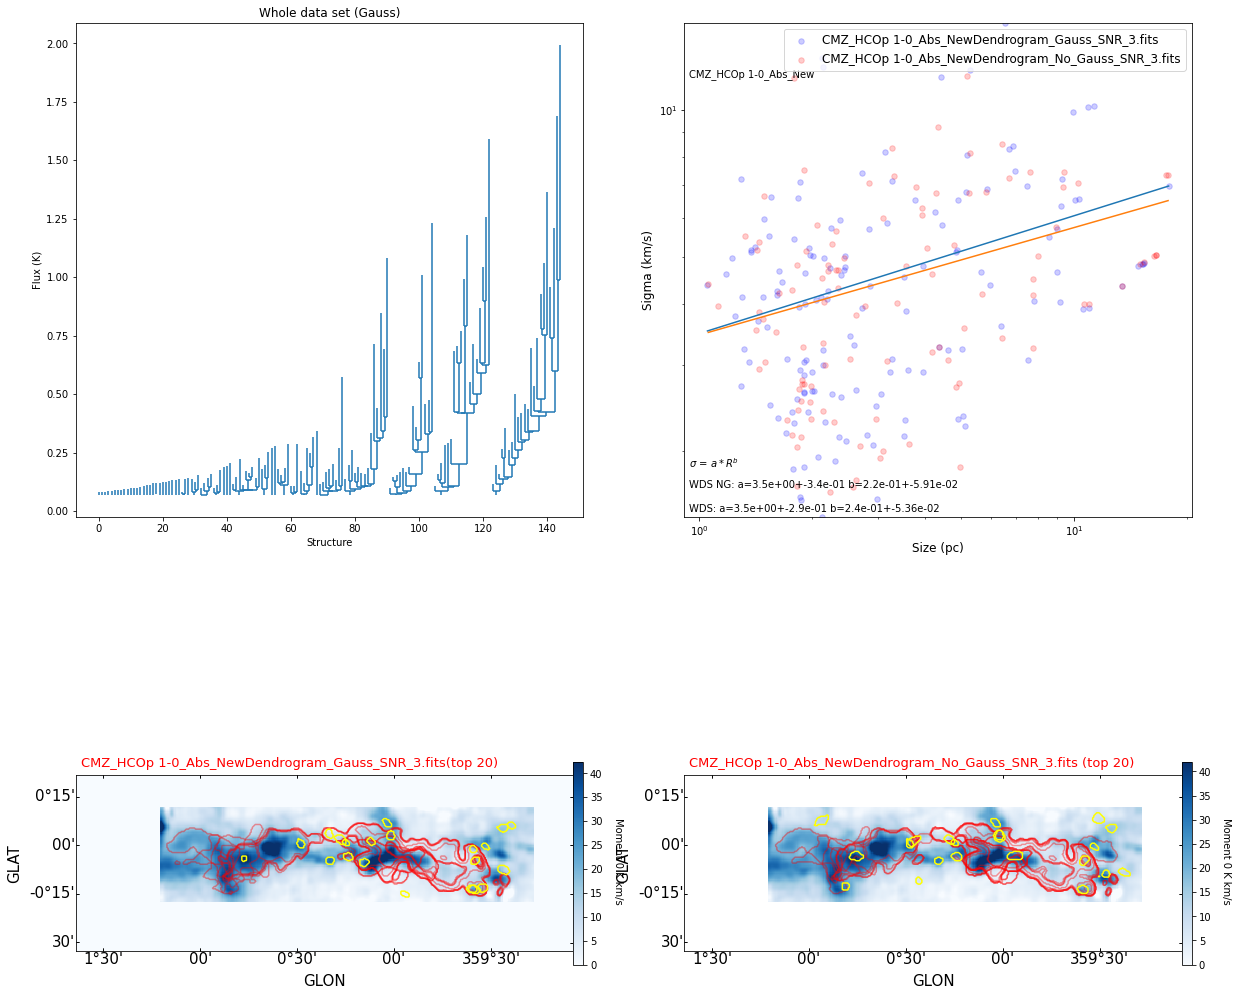

[211. 204.]
(183,)
(130,)
(152, 150, 425)
(152, 150, 425)
[[45, 120], [75, 388]] (150, 425)
[[45, 120], [75, 388]] (150, 425)
(117,)


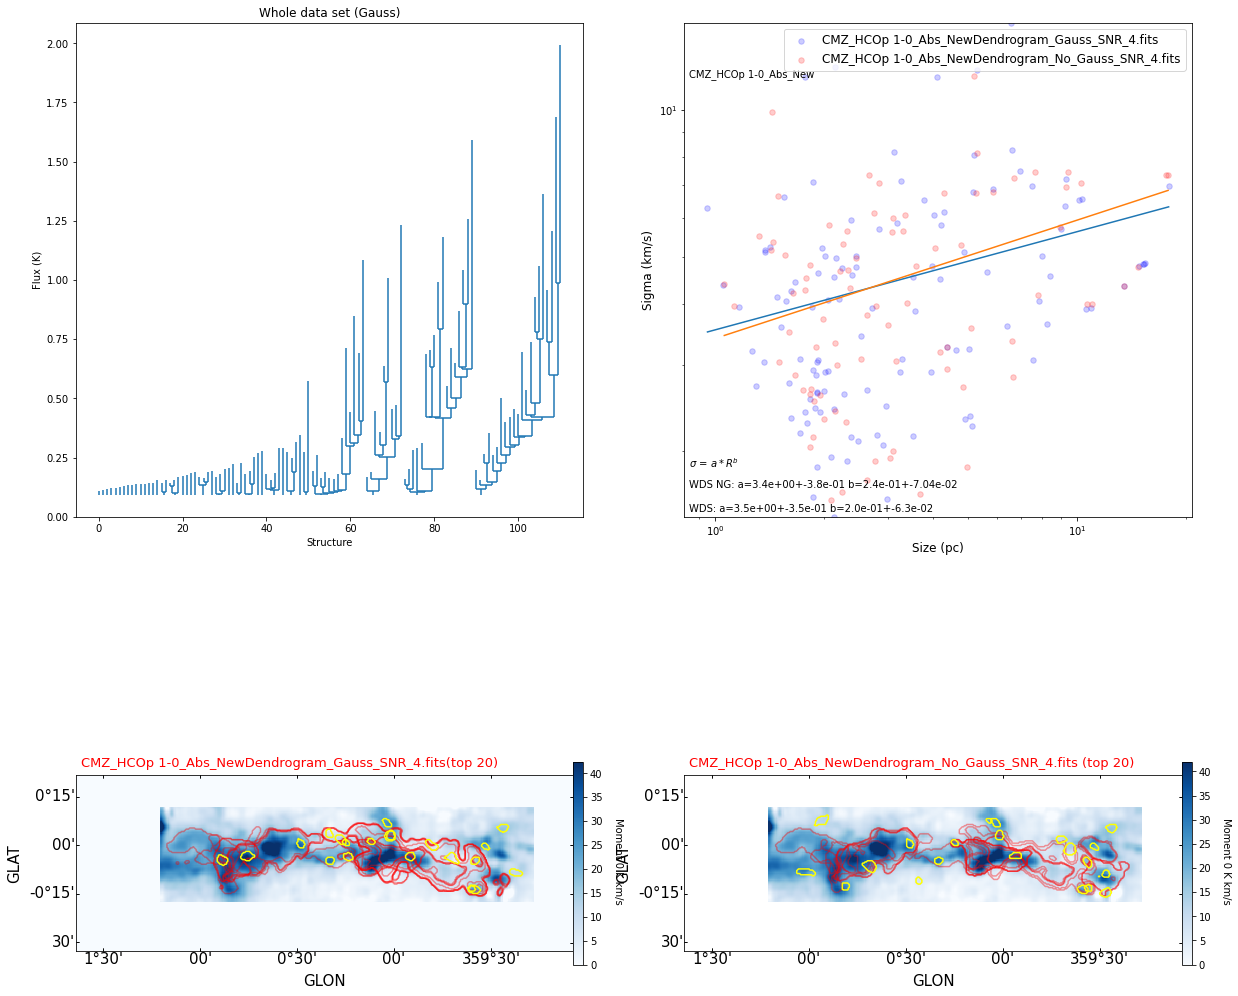

[155. 148.]
(146,)
(103,)
(152, 150, 425)
(152, 150, 425)
[[45, 120], [75, 388]] (150, 425)
[[45, 120], [75, 388]] (150, 425)
(98,)


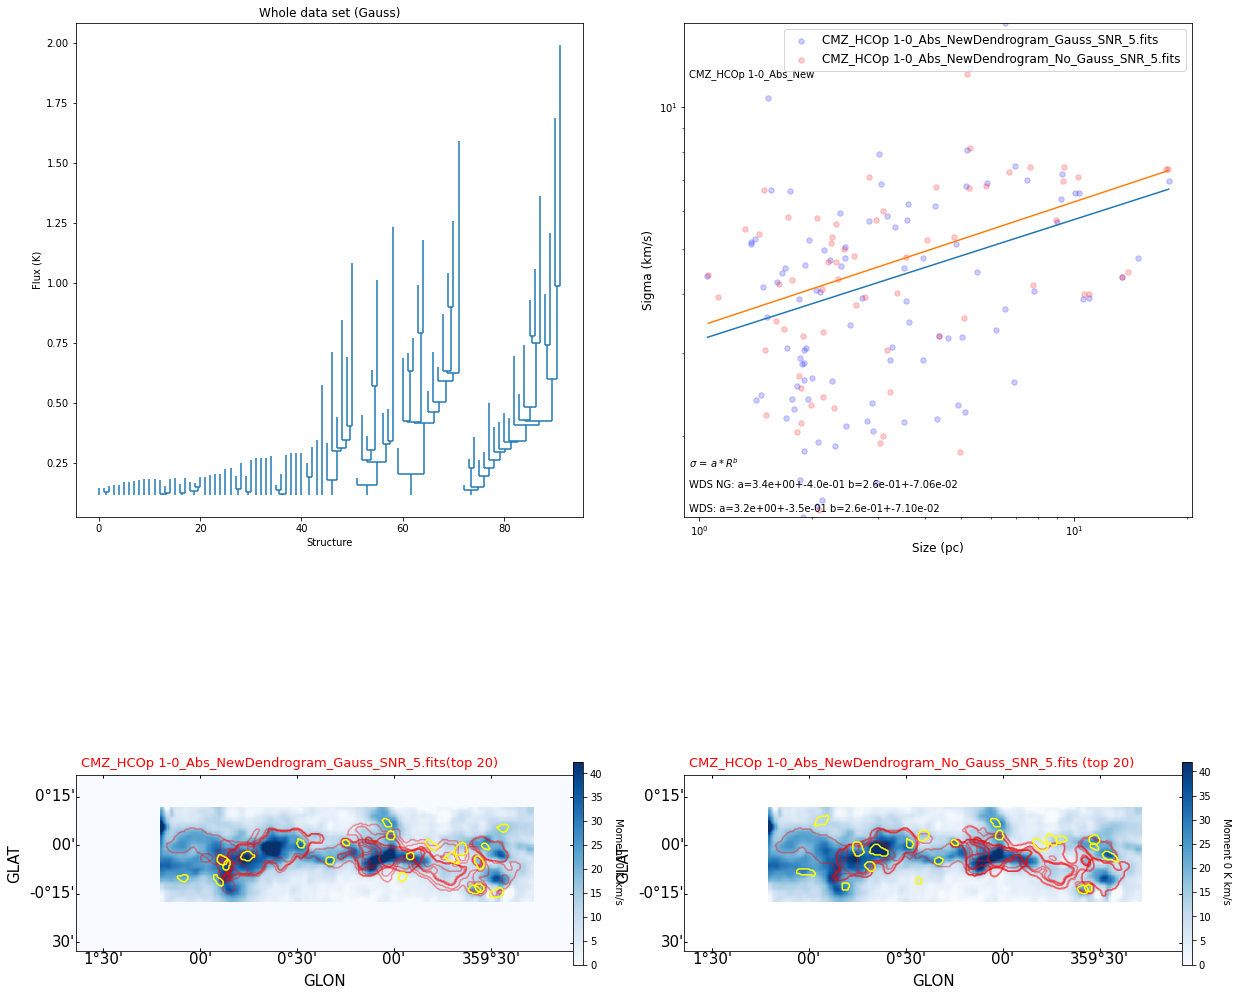

[121. 115.]
(118,)
(94,)
(152, 150, 425)
(152, 150, 425)
[[45, 120], [75, 388]] (150, 425)
[[45, 120], [75, 388]] (150, 425)
(77,)


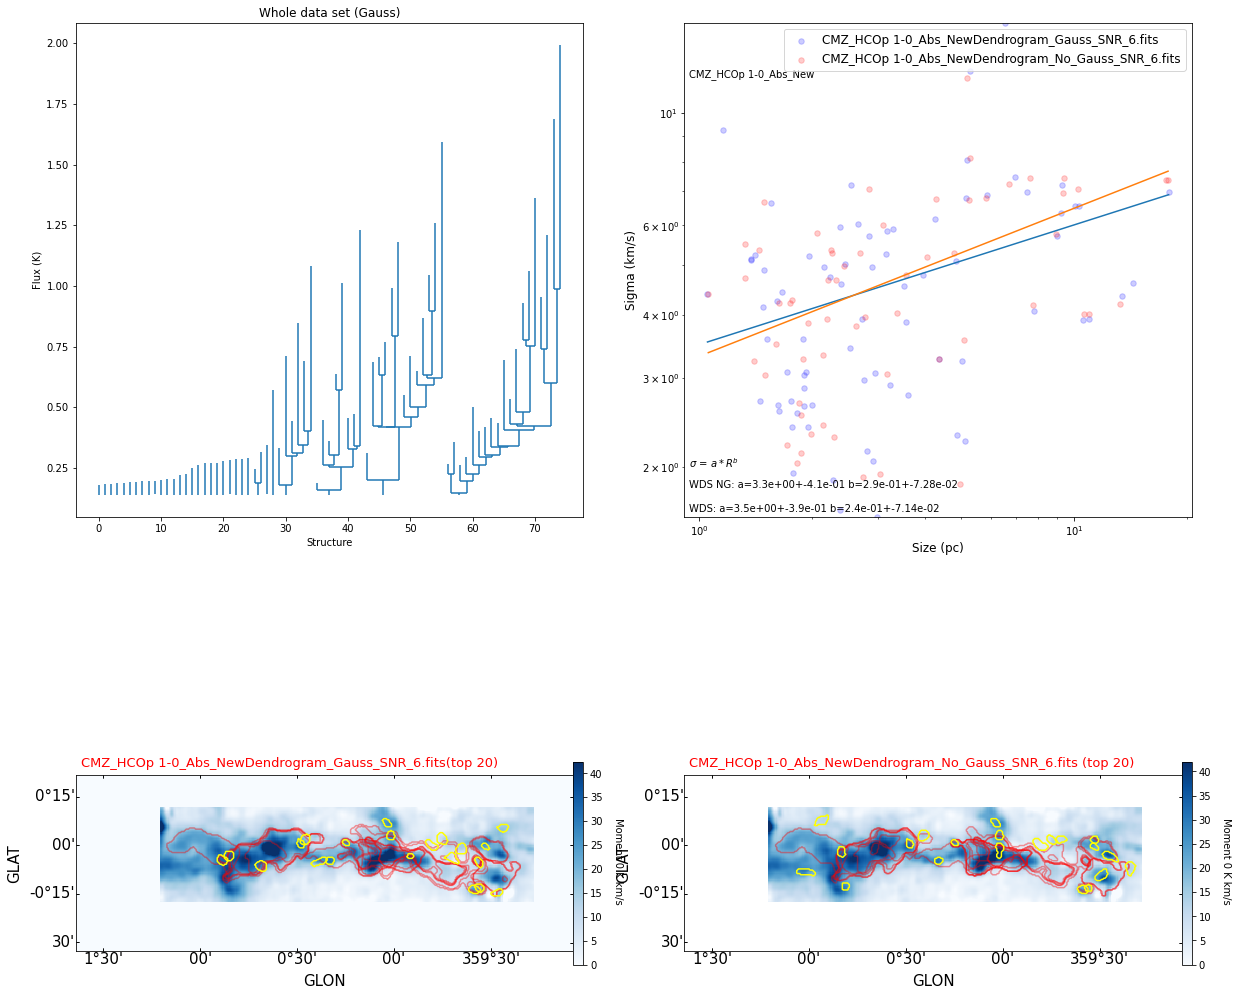

[63. 91.]
(105,)
(81,)
(152, 150, 425)
(152, 150, 425)
[[45, 120], [75, 388]] (150, 425)
[[45, 120], [75, 388]] (150, 425)
(70,)


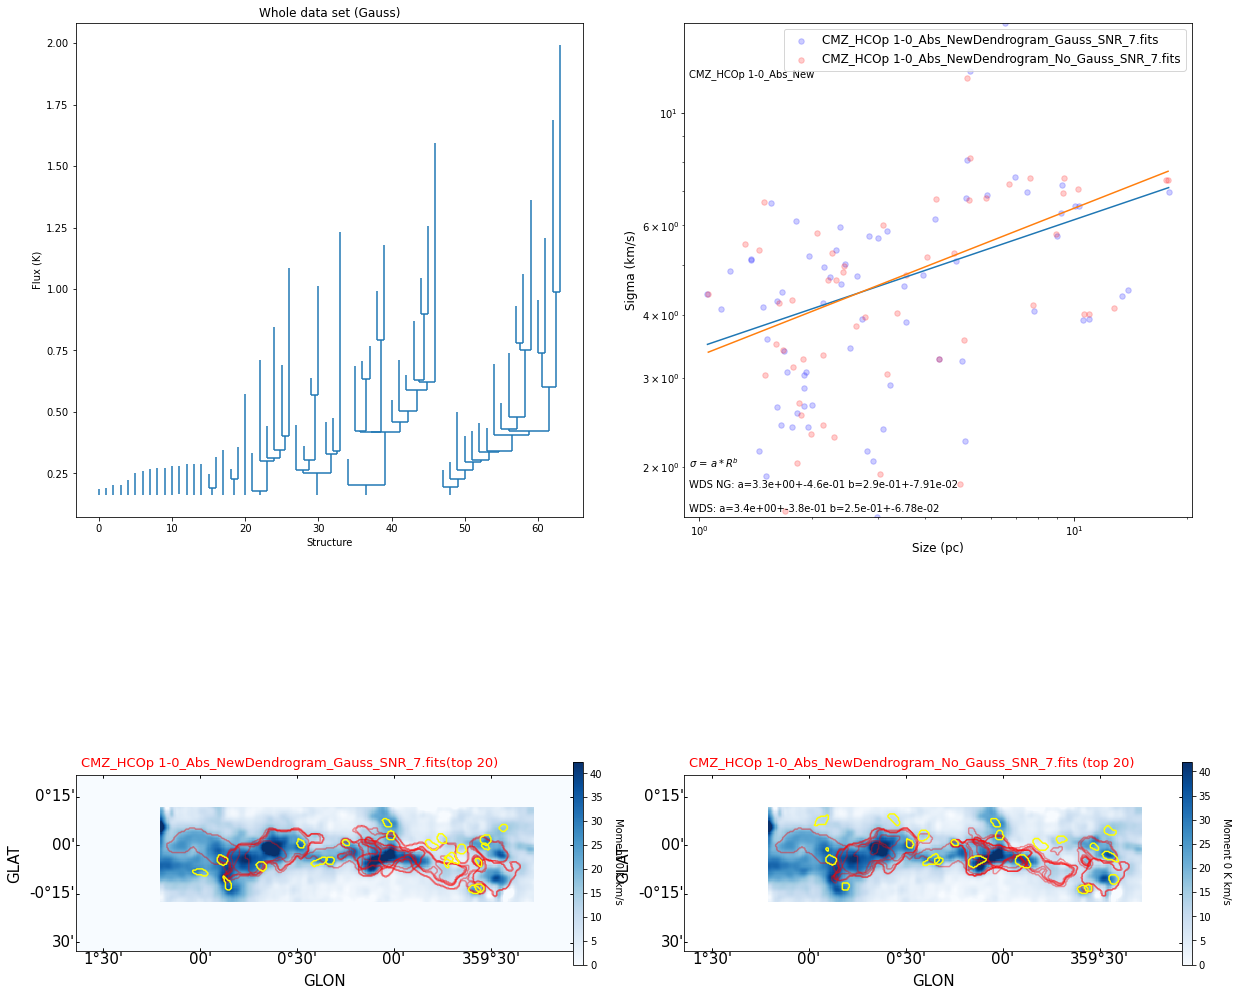

[50. 78.]


In [5]:
Num=0
Name = "CMZ_HCOp 1-0_Abs_New"
path="CMZ_Spliced_Reprojected_Whole_HCOp_10.fits"
path_No_Gauss="CMZ_Spliced_Reprojected_Whole_HCOp_10_No_Gauss.fits"
pathCont = 'CMZ_Continuum_Splice.fits'


#Make subcube

Qp = SpectralCube.read(path).with_spectral_unit(u.km/u.s,velocity_convention="radio") 
Qp.allow_huge_operations=True
Qp = Qp[:,:,:]#Get rid of the excess nan parts
Q = Qp.to(u.K)#Jy to Kelvin
sc = Q.unmasked_copy()
scW = sc.wcs[:][:][0]
dat = sc.hdu.data[int(len(sc)*((1-Ram_Limiter)/2)):int(len(sc)*(Ram_Limiter + (1-Ram_Limiter)/2)),:,:]
scn = sc[int(len(sc)*((1-Ram_Limiter)/2)):int(len(sc)*(Ram_Limiter + (1-Ram_Limiter)/2)),:,:]
scF = scn[:,75:225,225:650]#Crop(scn,scn.wcs[:][:][0],cen_p1,cen_p2,0,False)
datn = dat[:,75:225,225:650]#Crop(dat,scn.wcs[:][:][0],cen_p1,cen_p2,0,False)z

QpNG = SpectralCube.read(path_No_Gauss).with_spectral_unit(u.km/u.s,velocity_convention="radio") 
QpNG.allow_huge_operations=True
QpNG = QpNG[:,:,:]#Get rid of the excess nan parts
QNG = QpNG.to(u.K)#Jy to Kelvin
scNG = QNG.unmasked_copy()

datNG = scNG.hdu.data[int(len(scNG)*((1-Ram_Limiter)/2)):int(len(scNG)*(Ram_Limiter + (1-Ram_Limiter)/2)),:,:]
scNGF = scNG[int(len(scNG)*((1-Ram_Limiter)/2)):int(len(scNG)*(Ram_Limiter + (1-Ram_Limiter)/2)),:,:]
del scNG 
del QpNG 
del QNG

scNGF = scNGF[:,75:225,225:650]#Crop(dat,scn.wcs[:][:][0],cen_p1,cen_p2,0,False)z
datnNG = datNG[:,75:225,225:650]#Crop(dat,scn.wcs[:][:][0],cen_p1,cen_p2,0,False)z

Non_nan=((sc.hdu.data[0,:,:]>0)  | (sc.hdu.data[0,:,:]<0 ))

m = (np.nanstd(sc.hdu.data[0,:,:],where= Non_nan)) #Noise K

Non_nanNG=((datNG>0)  | (datNG<0 ))
mNG = (np.nanstd(datNG[0,:,:],where= Non_nan)) #Noise K



print("noise = ",m,"K")
print("noise ng = ",mNG,"K")

#Continuum image
scCont = spectral_cube.Projection.from_hdu(fits.open(pathCont)[0])


metadata = {}
metadata["distance"] = 8.178*10**-3*u.Mpc
arc_per_pix_yc =  abs(scContW.hdu.header["CDELT1"]*3600.0 * u.arcsec)/u.pix
arc_per_pix_xc =  abs(scContW.hdu.header["CDELT2"]*3600.0 * u.arcsec)/u.pix
beam_majorc =  scContW.hdu.header["BMAJ"]*3600.0 * u.arcsec
beam_minorc =  scContW.hdu.header["BMIN"]*3600.0 * u.arcsec
beam_area_ratioc = beam_minorc*beam_majorc/arc_per_pix_yc/arc_per_pix_xc*1.13309#beam_area_ratioc = beam_minorc*beam_majorc/arc_per_pix_yc/arc_per_pix_xc#This is for FWHM, use *(2*np.sqrt(2*np.log(2)))**2#For gaussian beam
metadata['beam_area_ratioc']=beam_area_ratioc
pc_per_pixelc = abs(scContW.hdu.header["CDELT1"])/180*np.pi*metadata['distance']/u.Mpc
header = scF.hdu.header
#make metadata for the dendrogram

try:
    freq = header["RESTFREQ"]*u.Hz#
    metadata['wavelength']=299792458*u.m/header["RESTFREQ"]#
    print(1,freq,metadata['wavelength'])
except:
    freq = header["RESTFRQ"]*u.Hz#
    metadata['wavelength']=299792458*u.m/header["RESTFRQ"]#
metadata['data_unit'] =scF[0][0][0].unit# header['BUNIT']
metadata['arc_per_pix_y'] =  abs(header["CDELT1"]*3600.0 * u.arcsec)/u.pix
metadata['arc_per_pix_x'] =  abs(header["CDELT2"]*3600.0 * u.arcsec)/u.pix


metadata['beam_major'] =  header["BMAJ"]*3600.0 * u.arcsec
metadata['beam_minor'] =  header["BMIN"]*3600.0 * u.arcsec
beam_area_ratio = metadata['beam_minor']*metadata['beam_major']/metadata['arc_per_pix_y']/metadata['arc_per_pix_x']*1.13309#beam_area_ratio = metadata['beam_minor']*metadata['beam_major']/metadata['arc_per_pix_y']/metadata['arc_per_pix_x']#This is for FWHM, use *(2*np.sqrt(2*np.log(2)))**2#For gaussian beam
metadata['beam_area_ratio']=beam_area_ratio
metadata['spatial_scale'] = np.sqrt(abs(header["CDELT1"])*u.degree**2*abs(header["CDELT2"]))
area_res = abs(header["CDELT1"])*abs(header["CDELT2"])*(np.pi/180*(8.178*10**-3))**2#mpc^2/pix^2
metadata["velocity_scale"] = abs(header["CDELT3"])*u.km/u.s#3.3714064157379937*u.km/u.s

metadata["vaxis"]=0



for lmi in range(5):
    dName = Name+"Dendrogram_Gauss_SNR_"+str((3+lmi))+".fits"
    dNameNG = Name +"Dendrogram_No_Gauss_SNR_"+str((3+lmi))+".fits"
    
    d=astrodendro.Dendrogram.load_from(dName)
    dNG=astrodendro.Dendrogram.load_from(dNameNG)
    print(np.shape(d))
    print(np.shape(dNG))
    print(np.shape(datn))
    print(np.shape(datnNG))
    vel,RA,Dec = scF.world[:,0,0]
    Rads,Sigmas,CD,Lumin,SIDS,MOM0FLUX = Dendro_Arrays(d,datn,vel,Continuum_Data,metadata)
    RadsNG,SigmasNG,CDNG,LuminNG,SIDSNG,MOM0FLUXNG = Dendro_Arrays(dNG,datnNG,vel,Continuum_Data,metadata)
    
    ##Analyze dendograms


    fig = plt.figure(1,figsize=(20,20))
    
    axAlpha = pylab.subplot(2, 2, 1)
    axDelta = pylab.subplot(2, 2, 3,projection=scF.moment0().wcs)
    axDelta2 = pylab.subplot(2, 2, 4,projection=scF.moment0().wcs)
    axDat = pylab.subplot(2, 2, 2)

    p1=d.plotter()
    p1.plot_tree(axAlpha)
    axAlpha.set_xlabel("Structure")
    axAlpha.set_ylabel("Flux (K)")
    axAlpha.set_title("Whole data set (Gauss)")

    #Plot contours for the top clusters
    scCropped =scF.moment0().hdu.data
    imBeta = axDelta.imshow(scCropped, origin='lower', interpolation='nearest', cmap=plt.cm.Blues,vmin=0,vmax = np.nanmax(scCropped)*.7 )
    Rcon = np.concatenate((Rads[0],Rads[1]))
    
    nth = sorted(Rcon)[len(Rcon)-20]
    G1 = True
    SIDScon=np.concatenate((SIDS[0],SIDS[1]))
    for n in range(len(Rcon)):
        if(Rcon[n]>=nth):
            if(G1):
                G1=False
                p1.plot_contour(axDelta, structure=int(SIDScon[n]), lw=1, colors='red',label="Higest Size",alpha=.4)
            else:
                pass
                p1.plot_contour(axDelta, structure=int(SIDScon[n]), lw=1, colors='red',alpha=.4)
    nth = sorted(Rcon)[20]
    G1 = True
    SIDScon=np.concatenate((SIDS[0],SIDS[1]))
    for n in range(len(Rcon)):
        if(Rcon[n]<=nth):
            if(G1):
                G1=False
                p1.plot_contour(axDelta, structure=int(SIDScon[n]), lw=1, colors='yellow',label="Lowest Size",alpha=1)
            else:
                p1.plot_contour(axDelta, structure=int(SIDScon[n]), lw=1, colors='yellow',alpha=1)
    RA = axDelta.coords[0]                                                                  # 
    Dec = axDelta.coords[1]
    RA.set_ticks(size=-3)                                                                                      
    Dec.set_ticks(size=-3) 
    RA.set_ticklabel(exclude_overlapping=True) 
    Dec.set_ticklabel(exclude_overlapping=True)                                                                                     
    axDelta.set_xlabel('GLON',fontsize=15,labelpad=1)                               
    axDelta.set_ylabel('GLAT',fontsize=15,labelpad=1)
    axDelta.tick_params(axis = 'both', which = 'major', labelsize = 15)    
    cb=pylab.colorbar(imBeta,fraction=0.02,pad=0.00,ax=axDelta)                                     
    cb.set_label(label=("Moment 0 K km/s "),fontsize=10,rotation=270,labelpad=20) 
    cb.ax.tick_params(which = 'major', labelsize = 10)   
    axDelta.annotate(s=(dName+"(top 20)"),fontsize=13,xy=(.01,1.05),xycoords="axes fraction",c="red")  
    
    #Same but for no gauss
    
    #Plot contours for the top clusters
    p2=dNG.plotter()
    scCroppedNG =scNGF.moment0().hdu.data
    imBetaNG = axDelta2.imshow(scCroppedNG, origin='lower', interpolation='nearest', cmap=plt.cm.Blues,vmin=0,vmax = np.nanmax(scCroppedNG)*.7 )
    RconNG = np.concatenate((RadsNG[0],RadsNG[1]))
    nthNG = sorted(RconNG)[len(RconNG)-20]
    G1 = True
    SIDSconNG=np.concatenate((SIDSNG[0],SIDSNG[1]))
    for n in range(len(RconNG)):
        if(RconNG[n]>=nthNG):
            if(G1):
                G1=False
                p2.plot_contour(axDelta2, structure=int(SIDSconNG[n]), lw=1, colors='red',label="Higest Size",alpha=.4)
            else:
                p2.plot_contour(axDelta2, structure=int(SIDSconNG[n]), lw=1, colors='red',alpha=.4)
    nth = sorted(RconNG)[20]
    G1 = True
    
    for n in range(len(RconNG)):
        if(RconNG[n]<=nth):
            if(G1):
                G1=False
                p2.plot_contour(axDelta2, structure=int(SIDSconNG[n]), lw=1, colors='yellow',label="Lowest Size",alpha=1)
            else:
                p2.plot_contour(axDelta2, structure=int(SIDSconNG[n]), lw=1, colors='yellow',alpha=1)
    RA = axDelta2.coords[0]                                                                  # 
    Dec = axDelta2.coords[1]
    RA.set_ticks(size=-3)                                                                                      
    Dec.set_ticks(size=-3) 
    RA.set_ticklabel(exclude_overlapping=True) 
    Dec.set_ticklabel(exclude_overlapping=True)                                                                                     
    axDelta2.set_xlabel('GLON',fontsize=15,labelpad=1)                               
    axDelta2.set_ylabel('GLAT',fontsize=15,labelpad=1)
    axDelta2.tick_params(axis = 'both', which = 'major', labelsize = 15)    
    cb2=pylab.colorbar(imBetaNG,fraction=0.02,pad=0.00,ax=axDelta2)                                     
    cb2.set_label(label=("Moment 0 K km/s "),fontsize=10,rotation=270,labelpad=20) 
    cb2.ax.tick_params(which = 'major', labelsize = 10)   
    axDelta2.annotate(s=(dNameNG+" (top 20)"),fontsize=13,xy=(.01,1.05),xycoords="axes fraction",c="red")  


    pc_per_pixel = abs(header["CDELT1"])/180*np.pi*metadata['distance']/u.Mpc

    #Finds Size, Linewidth, Luminosity, and Column Density of a structure for each structure and returns them in [[][]] arrays [Leaves][Branches]

    def func(R,a,b):
        return a*R**(b)

    Scon = np.concatenate((Sigmas[0],Sigmas[1]))
    SconNG = np.concatenate((SigmasNG[0],SigmasNG[1]))
    
    print(np.shape(Rcon))
    poptCon, pcovCon = curve_fit(func, Rcon*10**6, Scon)
    poptCon2, pcovCon2 = curve_fit(func, RconNG*10**6, SconNG)
    xs=np.linspace(np.nanmin(Rcon*10**6),np.nanmax(Rcon*10**6),50)
    xsNG=np.linspace(np.nanmin(RconNG*10**6),np.nanmax(RconNG*10**6),50)

    ysCon=func(xs,poptCon[0],poptCon[1])
    ysConNG=func(xsNG,poptCon2[0],poptCon2[1])

    
    xpcon = axDat.scatter(Rcon*10**6,Scon,label=dName,s=30,alpha=.2,color="blue")
    p = axDat.plot(xs,ysCon)
    
    xpcon2 = axDat.scatter(RconNG*10**6,SconNG,label=dNameNG,s=30,alpha=.2,color='red')
    p2 = axDat.plot(xsNG,ysConNG)





    st="WDS: a="+ str(np.format_float_scientific(poptCon[0],1))+"+-"+str(np.format_float_scientific(np.sqrt(pcovCon[0][0]),1))+" b="+str(np.format_float_scientific(poptCon[1],1))+"+-"+str(np.format_float_scientific(np.sqrt(pcovCon[1][1]),2))
    st2="WDS NG: a="+ str(np.format_float_scientific(poptCon2[0],1))+"+-"+str(np.format_float_scientific(np.sqrt(pcovCon2[0][0]),1))+" b="+str(np.format_float_scientific(poptCon2[1],1))+"+-"+str(np.format_float_scientific(np.sqrt(pcovCon2[1][1]),2))
    axDat.annotate(s=st,fontsize=10,xy=(0.01,0.01),xycoords="axes fraction")
    axDat.annotate(s=st2,fontsize=10,xy=(0.01,0.06),xycoords="axes fraction")

    axDat.annotate(s=r'$\sigma$ = $a*R^b$',fontsize=10,xy=(0.01,0.10),xycoords="axes fraction")
    axDat.set_yscale('log')
    axDat.set_xscale('log')
    axDat.set_ylim(np.nanmin(Scon),np.nanmax(Scon))
    axDat.set_xlabel("Size (pc)",fontsize=12)
    axDat.set_ylabel("Sigma (km/s)",fontsize=12)
    axDat.legend(prop={'size': 12},loc="upper right")
    axDat.annotate(s=Name,fontsize=10,xy=(0.01,0.89),xycoords="axes fraction")


    pylab.show()



    #Must use text because np load is broken

    np.savetxt(dName+"Sigmas_Leaves", Sigmas[0],fmt='%s')
    np.savetxt(dName+"Sigmas_Branches", Sigmas[1],fmt='%s')
    np.savetxt(dName+"Radii_Leaves", Rads[0],fmt='%s')
    np.savetxt(dName+"Radii_Branches", Rads[1],fmt='%s')
    
    print(SIDScon[len(SIDScon)-3:len(SIDScon)-1])

